In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from core.sabr import fit, objective, predict
from core.manipulation import get_abs_strikes
from core.utils import get_prediction_for_row, plot_prediction_vs_reality

## Prepare market data

In [2]:
# Original data
df = pd.read_excel('C:\dev\OW-\data\market_data.xlsx') 
df.head(7)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Market Volatilities for strike spreads in bps:,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Tenor,Expiry,Fwd,-150.000,-100.0000,-50.0000,-25.0000,0.0000,25.0000,50.0000,100.0000,150.0000
1,2,0.25,0.0107638,0.000,1.0470,0.4812,0.4327,0.4268,0.4148,0.4253,0.4322,0.4495
2,2,0.5,0.0110992,0.000,0.9647,0.5079,0.4637,0.4477,0.4390,0.4377,0.4452,0.4576
3,2,0.75,0.0116024,0.000,0.8253,0.5033,0.4648,0.4494,0.4387,0.4348,0.4375,0.4463
4,2,1,0.0121936,0.000,0.6796,0.4788,0.4474,0.4501,0.4435,0.4478,0.4611,0.4754
5,2,2,0.016196,0.000,0.9119,0.5417,0.4628,0.4529,0.4461,0.4386,0.4387,0.4442
6,2,5,0.0284364,0.404,0.3541,0.3218,0.3107,0.3048,0.2975,0.2923,0.2873,0.2870


In [3]:
# Preprocessed data
df.columns = df.iloc[0]
df.drop(0, inplace=True)
df = df.astype(np.float64)
df.head(6)

,Tenor,Expiry,Fwd,-150.0,-100.0,-50.0,-25.0,0.0,25.0,50.0,100.0,150.0
1,2.0,0.25,0.010764,0.000,1.0470,0.4812,0.4327,0.4268,0.4148,0.4253,0.4322,0.4495
2,2.0,0.50,0.011099,0.000,0.9647,0.5079,0.4637,0.4477,0.4390,0.4377,0.4452,0.4576
3,2.0,0.75,0.011602,0.000,0.8253,0.5033,0.4648,0.4494,0.4387,0.4348,0.4375,0.4463
4,2.0,1.00,0.012194,0.000,0.6796,0.4788,0.4474,0.4501,0.4435,0.4478,0.4611,0.4754
5,2.0,2.00,0.016196,0.000,0.9119,0.5417,0.4628,0.4529,0.4461,0.4386,0.4387,0.4442
6,2.0,5.00,0.028436,0.404,0.3541,0.3218,0.3107,0.3048,0.2975,0.2923,0.2873,0.2870


In [4]:
df.tail(3)

,Tenor,Expiry,Fwd,-150.0,-100.0,-50.0,-25.0,0.0,25.0,50.0,100.0,150.0
34,30.00,5.0,0.027291,0.4261,0.3623,0.3189,0.3028,0.2921,0.2806,0.2729,0.2641,0.2614
35,30.00,10.0,0.025954,0.3664,0.3137,0.2792,0.2666,0.2575,0.2487,0.2420,0.2330,0.2286
36,3.75,2.2,0.030000,0.4200,0.3958,0.3903,0.0000,0.3800,0.0000,0.3911,0.3967,0.4180


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 1 to 36
Data columns (total 12 columns):
Tenor     36 non-null float64
Expiry    36 non-null float64
Fwd       36 non-null float64
-150.0    36 non-null float64
-100.0    36 non-null float64
-50.0     36 non-null float64
-25.0     36 non-null float64
0.0       36 non-null float64
25.0      36 non-null float64
50.0      36 non-null float64
100.0     36 non-null float64
150.0     36 non-null float64
dtypes: float64(12)
memory usage: 3.7 KB


In [6]:
# Leave out the missing data rows
df = df[5:]
df = df[:-1]
df.head()

,Tenor,Expiry,Fwd,-150.0,-100.0,-50.0,-25.0,0.0,25.0,50.0,100.0,150.0
6,2.0,5.00,0.028436,0.4040,0.3541,0.3218,0.3107,0.3048,0.2975,0.2923,0.2873,0.2870
7,2.0,10.00,0.033873,0.3026,0.2725,0.2510,0.2422,0.2343,0.2279,0.2228,0.2161,0.2128
8,5.0,0.25,0.016017,1.1870,0.6027,0.4655,0.4278,0.4030,0.3879,0.3789,0.3710,0.3725
9,5.0,0.50,0.016802,0.9568,0.5800,0.4661,0.4339,0.4125,0.3969,0.3888,0.3801,0.3785
10,5.0,0.75,0.017682,0.8325,0.5562,0.4578,0.4288,0.4078,0.3914,0.3821,0.3719,0.3692


In [7]:
df.tail(3)

,Tenor,Expiry,Fwd,-150.0,-100.0,-50.0,-25.0,0.0,25.0,50.0,100.0,150.0
33,30.0,2.0,0.026400,0.5056,0.4248,0.3709,0.3506,0.3345,0.3201,0.3088,0.2942,0.2876
34,30.0,5.0,0.027291,0.4261,0.3623,0.3189,0.3028,0.2921,0.2806,0.2729,0.2641,0.2614
35,30.0,10.0,0.025954,0.3664,0.3137,0.2792,0.2666,0.2575,0.2487,0.2420,0.2330,0.2286


In [8]:
df.reset_index(inplace=True)
df.head()

,index,Tenor,Expiry,Fwd,-150.0,-100.0,-50.0,-25.0,0.0,25.0,50.0,100.0,150.0
0,6,2.0,5.00,0.028436,0.4040,0.3541,0.3218,0.3107,0.3048,0.2975,0.2923,0.2873,0.2870
1,7,2.0,10.00,0.033873,0.3026,0.2725,0.2510,0.2422,0.2343,0.2279,0.2228,0.2161,0.2128
2,8,5.0,0.25,0.016017,1.1870,0.6027,0.4655,0.4278,0.4030,0.3879,0.3789,0.3710,0.3725
3,9,5.0,0.50,0.016802,0.9568,0.5800,0.4661,0.4339,0.4125,0.3969,0.3888,0.3801,0.3785
4,10,5.0,0.75,0.017682,0.8325,0.5562,0.4578,0.4288,0.4078,0.3914,0.3821,0.3719,0.3692


In [9]:
df.drop(columns=["index"], inplace=True)
df

,Tenor,Expiry,Fwd,-150.0,-100.0,-50.0,-25.0,0.0,25.0,50.0,100.0,150.0
0,2.0,5.00,0.028436,0.4040,0.3541,0.3218,0.3107,0.3048,0.2975,0.2923,0.2873,0.2870
1,2.0,10.00,0.033873,0.3026,0.2725,0.2510,0.2422,0.2343,0.2279,0.2228,0.2161,0.2128
2,5.0,0.25,0.016017,1.1870,0.6027,0.4655,0.4278,0.4030,0.3879,0.3789,0.3710,0.3725
3,5.0,0.50,0.016802,0.9568,0.5800,0.4661,0.4339,0.4125,0.3969,0.3888,0.3801,0.3785
4,5.0,0.75,0.017682,0.8325,0.5562,0.4578,0.4288,0.4078,0.3914,0.3821,0.3719,0.3692
5,5.0,1.00,0.018623,0.7242,0.5240,0.4446,0.4210,0.4042,0.3904,0.3807,0.3699,0.3668
6,5.0,2.00,0.022384,0.5704,0.4686,0.4119,0.3925,0.3781,0.3656,0.3561,0.3438,0.3380
7,5.0,5.00,0.030539,0.3720,0.3304,0.3016,0.2910,0.2816,0.2758,0.2700,0.2617,0.2572
8,5.0,10.00,0.033460,0.3108,0.2749,0.2488,0.2387,0.2304,0.2237,0.2184,0.2115,0.2083
9,10.0,0.25,0.022990,0.6333,0.4909,0.4010,0.3679,0.3451,0.3314,0.3229,0.3128,0.3121


In [10]:
# Absoulte strike prices
abs_strikes=get_abs_strikes(df)
abs_strikes.head(5)

,Tenor,Expiry,Fwd,-150.0,-100.0,-50.0,-25.0,0.0,25.0,50.0,100.0,150.0
0,2.0,5.00,0.028436,0.013436,0.018436,0.023436,0.025936,0.028436,0.030936,0.033436,0.038436,0.043436
1,2.0,10.00,0.033873,0.018873,0.023873,0.028873,0.031373,0.033873,0.036373,0.038873,0.043873,0.048873
2,5.0,0.25,0.016017,0.001017,0.006017,0.011017,0.013517,0.016017,0.018517,0.021017,0.026017,0.031017
3,5.0,0.50,0.016802,0.001802,0.006802,0.011802,0.014302,0.016802,0.019302,0.021802,0.026802,0.031802
4,5.0,0.75,0.017682,0.002682,0.007682,0.012682,0.015182,0.017682,0.020182,0.022682,0.027682,0.032682


## Plot smiles


In [11]:
matplotlib.rcParams['figure.figsize'] = [15, 20]
sns.set(style="white")

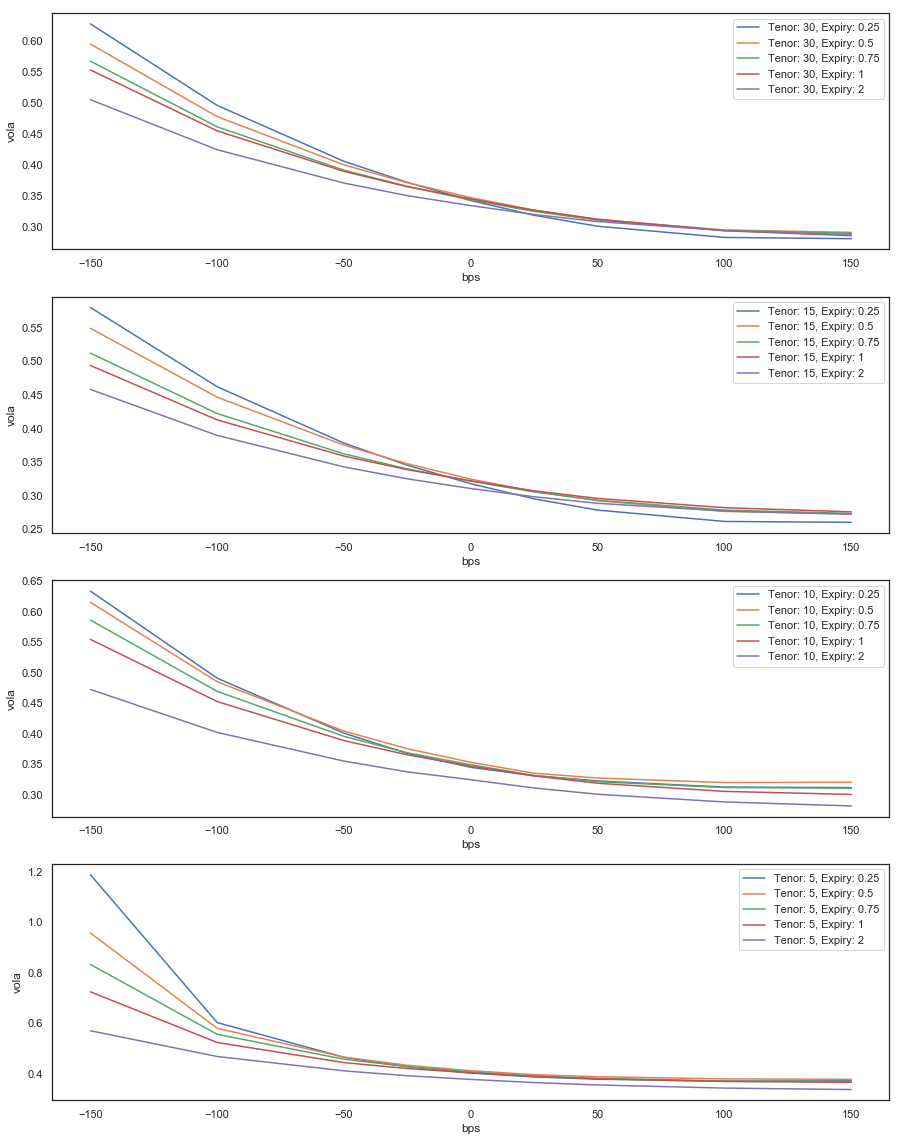

In [12]:
tenor_list = [30, 15, 10,5]
expiry_list = [0.25, 0.5, 0.75, 1, 2]
bps = np.array(df.columns[3:])
fig, axes = plt.subplots(nrows=4, ncols=1)

for ten in range(len(tenor_list)):
    for exp in range(len(expiry_list)):
        df_filtered = df[np.logical_and(df.Tenor==tenor_list[ten], df.Expiry == expiry_list[exp])]
        df_plot = pd.DataFrame({"bps": bps, "vola": np.array(df_filtered.iloc[0,3:])})
        sns.lineplot(x="bps", y="vola", data=df_plot, label= f"Tenor: {tenor_list[ten]}, Expiry: {expiry_list[exp]}", ax=axes[ten])

plt.show()

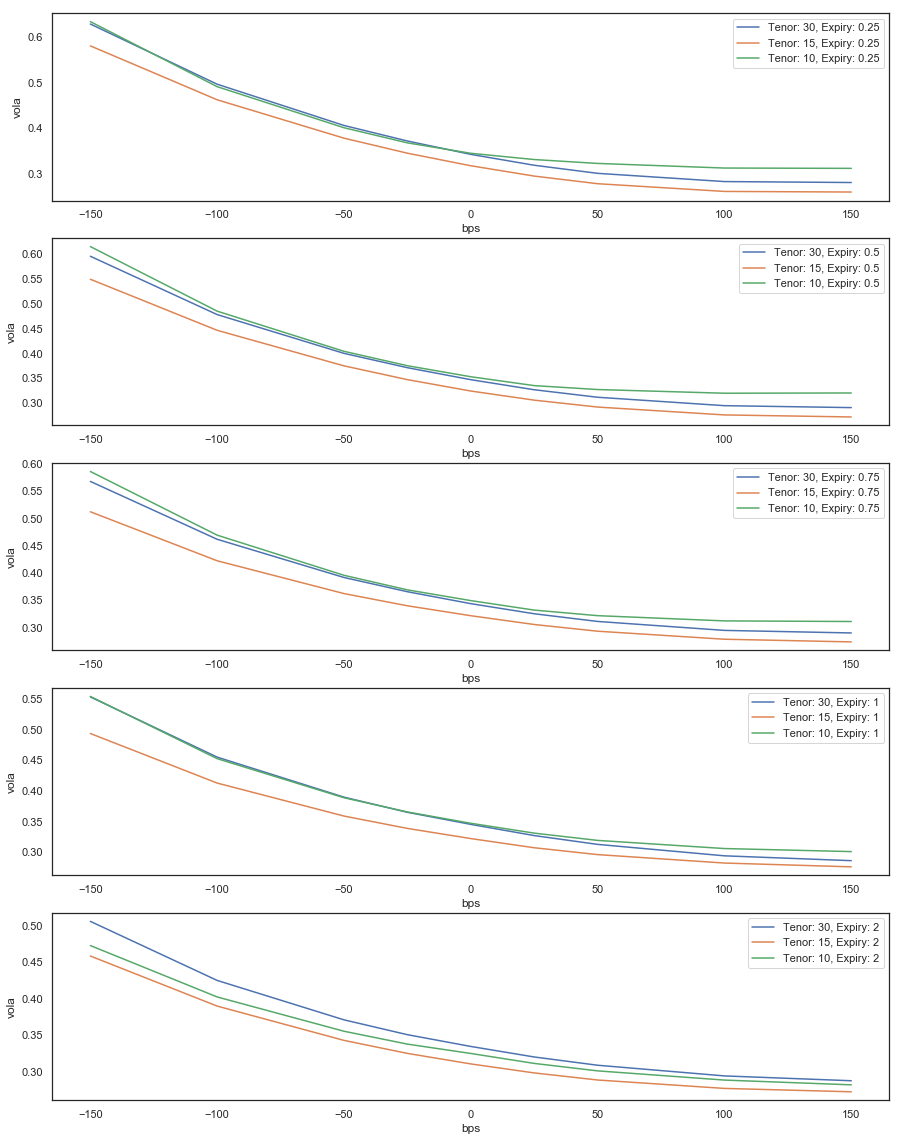

In [13]:
tenor_list = [30, 15, 10]
expiry_list = [0.25, 0.5, 0.75, 1, 2]
bps = np.array(df.columns[3:])
fig, axes = plt.subplots(nrows=5, ncols=1)

for exp in range(len(expiry_list)):
    for ten in range(len(tenor_list)):
        df_filtered = df[np.logical_and(df.Tenor==tenor_list[ten], df.Expiry == expiry_list[exp])]
        df_plot = pd.DataFrame({"bps": bps, "vola": np.array(df_filtered.iloc[0,3:])})
        sns.lineplot(x="bps", y="vola", data=df_plot, label= f"Tenor: {tenor_list[ten]}, Expiry: {expiry_list[exp]}", ax=axes[exp])

plt.show()

## Calibrating SABR

In [14]:
initial_guess = (0.01,0.5,0.,0.5)
fwds = np.array(df.Fwd)
expiries = np.array(df.Expiry)
strike_matrix = abs_strikes.iloc[:, 3:].to_numpy()
vola_matrix = df.iloc[:, 3:].to_numpy()

print(f"Shape fwds {fwds.shape}, Shape expiries {expiries.shape}\
        Strike matrix shape {strike_matrix.shape}, vola_matrix shape {vola_matrix.shape}")

Shape fwds (30,), Shape expiries (30,)        Strike matrix shape (30, 9), vola_matrix shape (30, 9)


In [15]:
optimal_parameters = fit(objective=objective,
                        initial_guess=initial_guess,
                        fwds=fwds,
                        expiries=expiries,
                        strike_matrix=strike_matrix,
                        vola_matrix=vola_matrix,
                        )

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003882012251000791
            Iterations: 16
            Function evaluations: 109
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0008294934611343563
            Iterations: 15
            Function evaluations: 103
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.09528249187699661
            Iterations: 16
            Function evaluations: 104
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.055172771129615224
            Iterations: 16
            Function evaluations: 104
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.03762643183910979
            Iterations: 17
      

In [16]:
row=15
get_prediction_for_row(predict, row, optimal_parameters, strike_matrix, vola_matrix, df)

Shape df (30, 12)
In row: 15, there is 
 strikes: [0.0160092 0.0210092 0.0260092 0.0285092 0.0310092 0.0335092 0.0360092
 0.0410092 0.0460092] 
 forward 0.0310092021008827 
 expiry 10.0 
 prediction [0.3352, 0.2968, 0.2679, 0.2564, 0.2469, 0.2389, 0.2327, 0.2252, 0.2228]
Rmse for row 15 is 0.0025119713374160825


([0.3352, 0.2968, 0.2679, 0.2564, 0.2469, 0.2389, 0.2327, 0.2252, 0.2228],
 0.0025119713374160825)

Shape df (30, 12)
In row: 15, there is 
 strikes: [0.0160092 0.0210092 0.0260092 0.0285092 0.0310092 0.0335092 0.0360092
 0.0410092 0.0460092] 
 forward 0.0310092021008827 
 expiry 10.0 
 prediction [0.3352, 0.2968, 0.2679, 0.2564, 0.2469, 0.2389, 0.2327, 0.2252, 0.2228]
Rmse for row 15 is 0.0025119713374160825


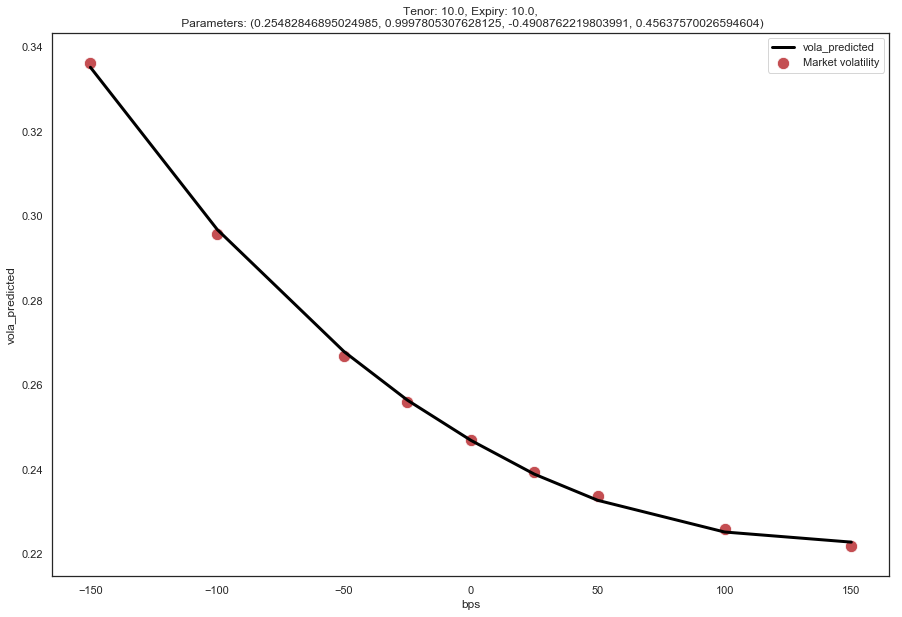

In [17]:
matplotlib.rcParams['figure.figsize'] = [15, 10]


plot_prediction_vs_reality(predict, row, optimal_parameters, strike_matrix, vola_matrix, df)

In [18]:
rmse = []
for row in range(df.shape[0]):
    pred, error = get_prediction_for_row(predict, row, optimal_parameters, strike_matrix, vola_matrix, df)
    rmse.append(error)
rmse=np.array(rmse)
print(f"\n RMSE: {rmse}")

Shape df (30, 12)
In row: 0, there is 
 strikes: [0.01343636 0.01843636 0.02343636 0.02593636 0.02843636 0.03093636
 0.03343636 0.03843636 0.04343636] 
 forward 0.0284363638504981 
 expiry 5.0 
 prediction [0.4024, 0.3556, 0.3233, 0.3115, 0.3047, 0.2956, 0.291, 0.2871, 0.2883]
Rmse for row 0 is 0.0038392707640905388
Shape df (30, 12)
In row: 1, there is 
 strikes: [0.01887347 0.02387347 0.02887347 0.03137347 0.03387347 0.03637347
 0.03887347 0.04387347 0.04887347] 
 forward 0.0338734710965737 
 expiry 10.0 
 prediction [0.3023, 0.2732, 0.2509, 0.2419, 0.2343, 0.2279, 0.2228, 0.216, 0.2129]
Rmse for row 1 is 0.0008366600265340431
Shape df (30, 12)
In row: 2, there is 
 strikes: [0.00101749 0.00601749 0.01101749 0.01351749 0.01601749 0.01851749
 0.02101749 0.02601749 0.03101749] 
 forward 0.0160174897353125 
 expiry 0.25 
 prediction [1.1489, 0.6692, 0.4864, 0.4262, 0.3838, 0.3608, 0.3558, 0.3753, 0.4059]
Rmse for row 2 is 0.09530970569674424
Shape df (30, 12)
In row: 3, there is 
 strik

In [19]:
rmse.mean()

0.013150460500902534

{'whiskers': [<matplotlib.lines.Line2D at 0x2b3f655b630>,
 'caps': [<matplotlib.lines.Line2D at 0x2b3f655bd30>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b3f655b208>],
 'medians': [<matplotlib.lines.Line2D at 0x2b3f6565470>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b3f65657f0>],
 'means': []}

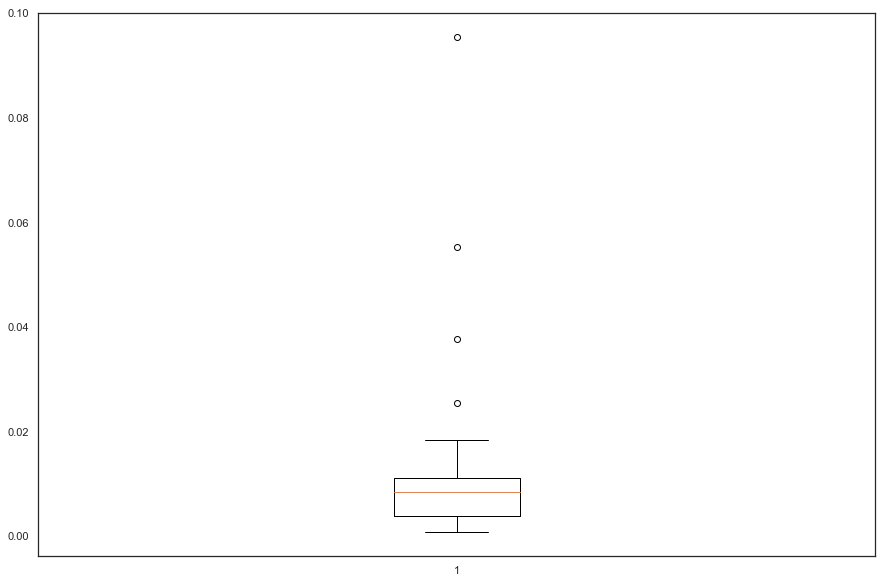

In [20]:
plt.boxplot(rmse)